In [1]:
import numpy as np
import tensorflow as tf
from utils.utils import get_data, train_test_split, get_scaled_closing_prices, create_sequences, show_chart, plot_test_predictions
from models.LSTM import LSTMModel
from models.RNN import RNNModel
import matplotlib.pyplot as plt

## Data Preparation ##
Download the data as csv file from Alpha Vantage and preprocess it to get the closing prices of the respective stock

In [2]:
# Select the stock of interest, here for example purpose: IBM
stock = "IBM"
full_data, closing_prices = get_data(stock)

In [3]:
# Get the scaled closing prices scaled to an interval of 0 - 1 for more stable training
# Scaling gives the factor to scale the output up again to the real value
scaled_closing_prices, scaling = get_scaled_closing_prices(closing_prices)

# Get the training and test split
train_set, test_set = train_test_split(scaled_closing_prices)

In [4]:
# Number of past days we take into consideration to predict the next closing price
window_size = 100

# Get input - output pairs from the given closing price sequence
train_X, train_Y = create_sequences(train_set, window_size)
test_X, test_Y = create_sequences(test_set, window_size)

# Prepare the data sets for the correct shape to be used in the LSTM
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

## RNN Model ##
Create and train the RNN model with the given window size and show the predictions on the test data compared to the true underlying curve

In [5]:
# Create LSTM model with respective window size and 50 rnn_units
rnn_model = RNNModel(window_size, 40)

# Train the model on the training set
rnn_model.train(train_X, train_Y, epochs=1001, batch_size=10, verbose=0)

# Get predictions on the test set
predictions_rnn = rnn_model.predict(test_X)

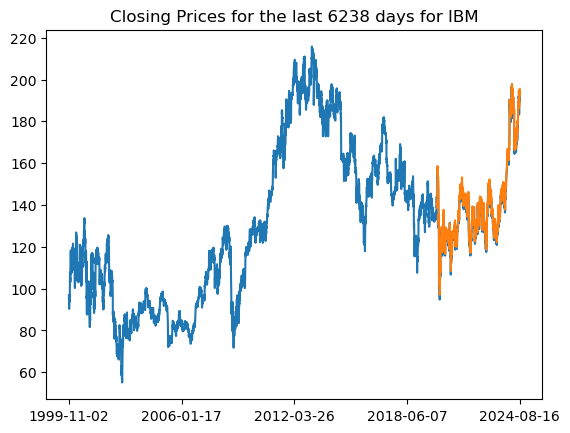

In [6]:
# Scale predictions to original price level
predictions_rnn = predictions_rnn * scaling

# Show predictions vs. underlying price curve for the test data
plot_test_predictions(full_data, closing_prices, predictions_rnn, stock, window_size)

## LSTM Model ##
Create and train the LSTM model with the given window size and show the predictions on the test data compared to the true underlying curve

In [7]:
# Create LSTM model with respective window size and 50 lstm_units
lstm_model = LSTMModel(window_size, 40)

# Train the model on the training set
lstm_model.train(train_X, train_Y, epochs=5001, batch_size=10, verbose=0)

# Get predictions on the test set
predictions_lstm = lstm_model.predict(test_X)

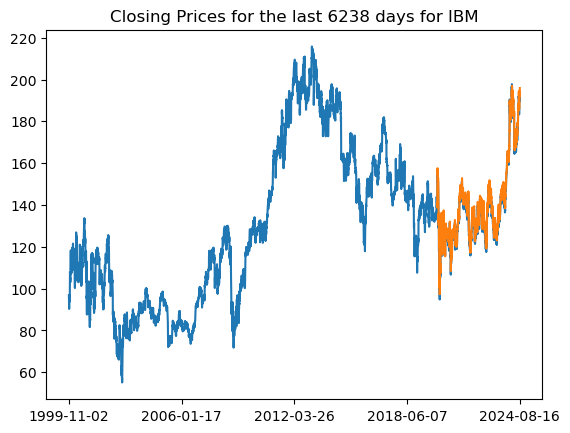

In [8]:
# Scale predictions to original price level
predictions_lstm = predictions_lstm * scaling

# Show predictions vs. underlying price curve for the test data
plot_test_predictions(full_data, closing_prices, predictions_lstm, stock, window_size)

## Comparison of RNN and LSTM ##
Compare the root mean squared error and the mean absolute error of the LSTM and the RNN given both have the same number of hidden layers and neurons.

In [9]:
# RMS and MAE of RNN Model
RMS_RNN = rnn_model.calculateRMS(test_Y, predictions_rnn)
MAE_RNN = rnn_model.calculateMAE(test_Y, predictions_rnn)

# RMS and MAE of LSTM Model
RMS_LSTM = lstm_model.calculateRMS(test_Y, predictions_lstm)
MAE_LSTM = lstm_model.calculateMAE(test_Y, predictions_lstm)

print('RNN Model, Score: %.2f RMS' % (RMS_RNN))
print('RNN Model, Score: %.2f MAE' % (MAE_RNN))
print('LSTM Model, Score: %.2f RMS' % (RMS_RNN))
print('LSTM Model, Score: %.2f MAE' % (MAE_RNN))

RNN Model, Score: 141.21 RMS
RNN Model, Score: 139.83 MAE
LSTM Model, Score: 141.21 RMS
LSTM Model, Score: 139.83 MAE


## Saving the Models ##
Save the trained models in the models/trained_models folder for later usage

In [10]:
link_to_folder = "models/trained_models/"

# Get summary and save RNN model
# rnn_model.summary()
rnn_model.save(link_to_folder)

# Get summary and save LSTM model
# lstm_model.summary()
lstm_model.save(link_to_folder)

## Reloading the model ##
Reloading the model for prediction of the next closing price

In [11]:
# Reloading the model
loaded_model_rnn = tf.keras.models.load_model(link_to_folder + 'rnn_model.keras')
loaded_model_lstm = tf.keras.models.load_model(link_to_folder + 'lstm_model.keras')


# Show the model architecture
loaded_model_rnn.summary()
loaded_model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 40)             │         5,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,045 (66.59 KB)

 Trainable params: 5,681 (22.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,364 (44.39 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,805 (264.87 KB)

 Trainable params: 22,601 (88.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,204 (176.58 KB)

## Predicting Closing Price for tomorrow ##

In [15]:
# Create the sequence for prediction
predict_X = scaled_closing_prices[-window_size:].to_numpy()

# Take the full history to predict the next days value
predict_X = np.reshape(predict_X, (predict_X.shape[1], 1, predict_X.shape[0]))

In [16]:
# Get the price prediction for the next day
price_next_day_rnn = loaded_model_rnn.predict(predict_X, verbose=0) * scaling
print("Prediction for tomorrow: " + f"{price_next_day_rnn.item():.2f}" + ' $')

Prediction for tomorrow: 196.03 $


In [17]:
# Get the price prediction for the next day
price_next_day_lstm = loaded_model_lstm.predict(predict_X, verbose=0) * scaling
print("Prediction for tomorrow: " + f"{price_next_day_lstm.item():.2f}" + ' $')

Prediction for tomorrow: 196.70 $
